In [1]:
%matplotlib inline
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssg
import tensorly as tl
from scipy.fftpack import rfft, irfft, dct, idct
from tensorly.decomposition import parafac

In [2]:
# introduce some utility functions

def repeat(ts: np.ndarray, times: int) -> np.ndarray:
    assert ts.ndim == 1
    out = np.array(ts)
    for _ in range(times - 1):
        out = np.r_[out, ts]
    return out


def fold(X: np.ndarray, n_p: int):
    """fold first mode into n_p tubes"""
    newshape = [-1, n_p] + list(X.shape[1:])
    return np.reshape(X, newshape)


def multifold(X: np.ndarray, n_ps: List[int]):
    for n_p in n_ps:
        X = fold(X, n_p)
    return X


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(
        np.square(y_true - y_pred).mean()
    )

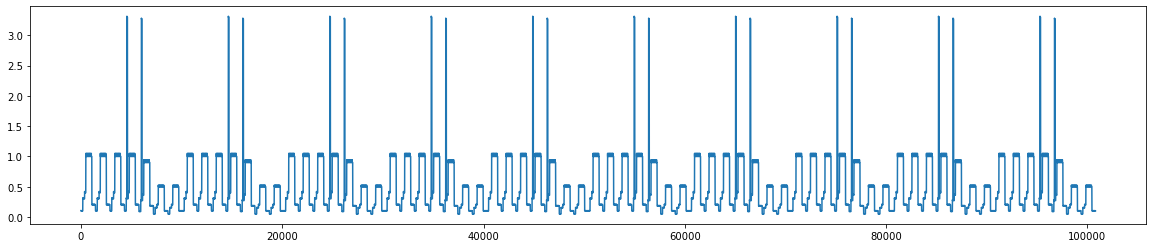

In [3]:
# generate data

w1 = np.array([1, 1, 1, 1, 0.9, 0.5, 0.5])
h1 = np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.4, 0.4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, .2, .2, .2, .2, .2, .2])
m1 = np.ones(60)
m1[:10] = 1.05

w2 = np.array([0, 0, 0, 1, 1, 0, 0])
h2 = np.zeros(24)
m2 = np.ones(60)
h2[4] = 3

plt.subplots(figsize=(20, 4))

Z = np.outer(np.outer(w1, h1), m1)
Z += np.outer(np.outer(w2, h2), m2)

ts = Z.ravel()

plt.plot(repeat(ts, 10))

In [4]:
data = repeat(ts, 10)
data += np.random.rand(*data.shape) * 1e-1

### TODOs

- Add noise to this time series
- Forecast this time series with R forecast. 
- Approximate this time series via DFT. 

### DCT reconstruction

In this section, we look at the quality of reconstruction we take with 5, 10, 15 ... elements of the discrete cosine transform (DCT). For this, we take the highest magnitude elements one by one and zero out the rest of the frequencies and reconstruct the time-domain reconstruction via inverse DCT. 

In [5]:
def dct_reconstruct(data: np.ndarray, n: int):
    z = dct(data)  # take the DCT

    # get the frequencies with most magnitude
    top_n = np.argsort(np.abs(z))[-n:]
    
    mask = np.zeros(len(z), dtype=bool)
    mask[top_n] = True

    # zero out the other frequencies
    z_masked = np.array(z)
    z_masked[~mask] = 0 

    # reconstruct
    return dct(z_masked, type=3) / len(z) / 2

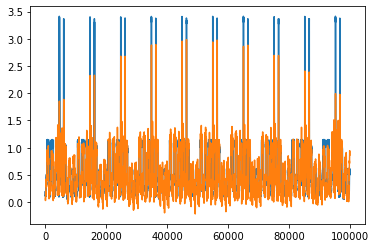

In [6]:
data_approx = dct_reconstruct(data, 100)
plt.plot(data[:100000])
plt.plot(data_approx[:100000])

### DFT Reconstruction

In [7]:
def dft_reconstruct(data: np.ndarray, n: int):
    z = rfft(data)  # take the DCT

    # get the frequencies with most magnitude
    top_n = np.argsort(np.abs(z))[-n:]
    
    mask = np.zeros(len(z), dtype=bool)
    mask[top_n] = True

    # zero out the other frequencies
    z_masked = np.array(z)
    z_masked[~mask] = 0 

    # reconstruct
    return irfft(z_masked)

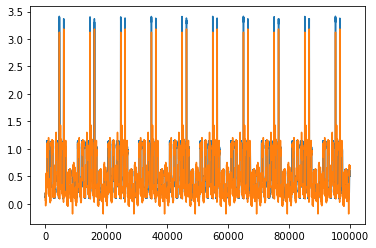

In [8]:
data_approx = dft_reconstruct(data, 100)
plt.plot(data[:100000])
plt.plot(data_approx[:100000])

### Tensor Reconstruction

In [73]:
# tensor reconstruction
def tensor_reconstruction(data: np.ndarray, folds: List[int], rank: int):
    tensor = multifold(data, folds)
    fac = parafac(tensor, rank=rank, n_iter_max=10000, tol=1.0e-15, linesearch=True)
    return tl.cp_to_tensor(fac).ravel(), np.sum([f.size for f in fac[1]])


In [10]:
data_approx, nr_params = tensor_reconstruction(data, [60, 24, 7], 2)

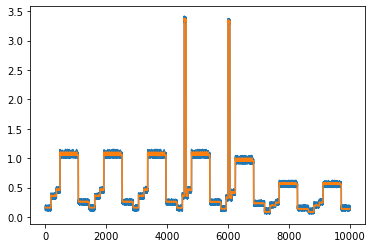

In [11]:
plt.plot(data[:10000])
plt.plot(data_approx[:10000])

### Comparing the two approaches with noisy data

In [37]:
data = repeat(ts, 10)
data += np.random.rand(*data.shape) * 1e-1

In [38]:
len(data)

100800

In [31]:
def dct_dft_errors(data, max_params):
    # RMSEs with DCT
    param_sweep = np.floor(np.linspace(1, max_params, 1000)).astype(int)
    dct_errors = [
        rmse(data, dct_reconstruct(data, p))
        for p in param_sweep
    ]

    # RMSEs with DFT
    dft_errors = [
        rmse(data, dft_reconstruct(data, p))
        for p in param_sweep
    ]
    return dct_errors, dft_errors

In [32]:
dct_errors, dft_errors = dct_dft_errors(data, 10000)

In [80]:
def tensor_error(data, folds, ranks):
    # with tensors
    tensor_results = []
    for rank in ranks:
        _ = print(rank) if rank % 3 == 0 else None
        data_approx, npars = tensor_reconstruction(data,folds, rank)
        tensor_results.append(
            [rmse(data, data_approx), npars]
        )
    ten_errors, ten_params = zip(*tensor_results)
    return ten_errors, ten_params

In [81]:
ten_errors, ten_params = tensor_error(data, folds=[60, 24, 7], ranks=[1, 2, 3, 4, 5, 6])

ValueError: cannot reshape array of size 34944 into shape (60)

In [82]:
def plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds):
    f, ax = plt.subplots(figsize=(8, 6))
    ax.plot(param_sweep, dct_errors, 'b.-', label="DCT")
    ax.plot(param_sweep, dft_errors, 'g.-', label="DFT")
    ax.plot(ten_params, ten_errors, 'r.-', label="Tensor Seasonality")
    ax.axvline(np.product(folds), color='grey', linestyle='--', label='$\dim \, \mathbf{s}$')
    ax.set(xlabel="# Parameters (logarithmic)", ylabel="RMSE")
    ax.legend()
    ax.semilogx();

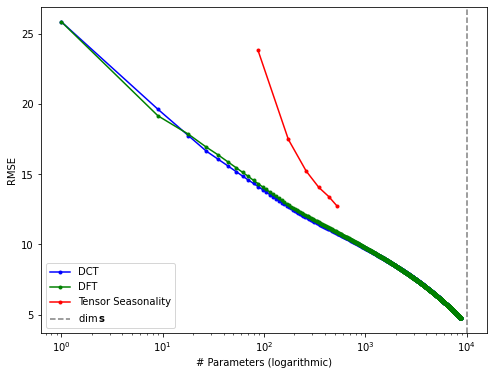

In [83]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, [60, 24, 7])

## GluonTS Datasets

In [14]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import pandas as pd

In [16]:
dataset_recipes.keys()

odict_keys(['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly'])

In [119]:
def get_plot_data(idx, train_datas, test_datas, freq, plot=True):
    data = pd.concat((to_pandas(train_datas[idx]), to_pandas(test_datas[idx])))
    data.index = pd.date_range(start=data.index[0], freq=freq, periods=len(data))
    if plot:
        data.plot();
    return data

def get_gluonts_dataset(dataset_name):
    dataset = get_dataset("traffic", regenerate=False)
    train_datas = list(iter(dataset.train))
    test_datas = list(iter(dataset.test))
    lens = [len(d["target"]) for d in train_datas]
    freqs = [d["start"].freqstr for d in train_datas]
    print(pd.Series(lens).value_counts())
    print(pd.Series(freqs).value_counts())
    del dataset
    return train_datas, test_datas, lens, freqs

### Electricity Dataset

In [106]:
train_datas, test_datas, lens, freqs = get_gluonts_dataset(dataset_name="electricity")

INFO:root:using dataset already processed in path /home/melih/.mxnet/gluon-ts/datasets/traffic.


14036    862
dtype: int64
H    862
dtype: int64


In [110]:
folds = [24, 7, 52]
freq="H"

<AxesSubplot:>

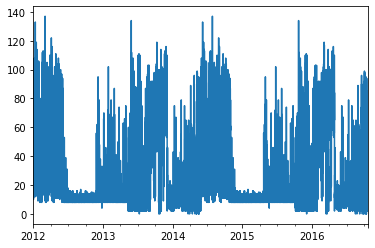

In [44]:
idx=0
data = get_plot_data(idx, train_datas, test_datas, freq)

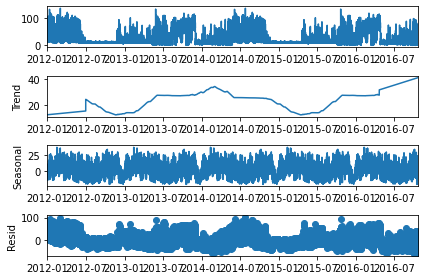

In [46]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive',period=np.prod(folds),extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


3
6
9


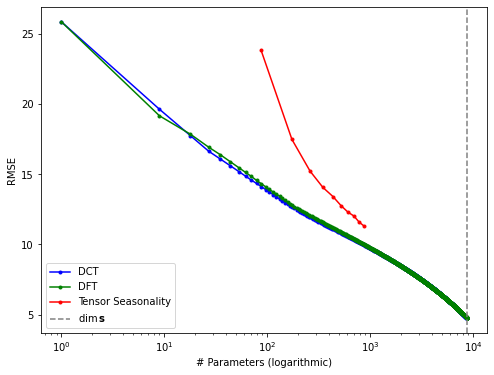

In [84]:
data -= decomposition.trend
data = data[len(data) % np.prod(folds):]

dct_errors, dft_errors = dct_dft_errors(data, np.prod(folds))
ten_errors, ten_params = tensor_error(data.values, folds=[24, 7, 52], ranks=list(range(1,11)))
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds)

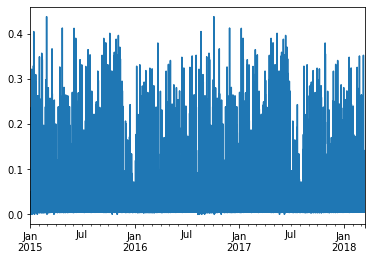

In [111]:
idx=1
data = get_plot_data(idx, train_datas, test_datas, freq)

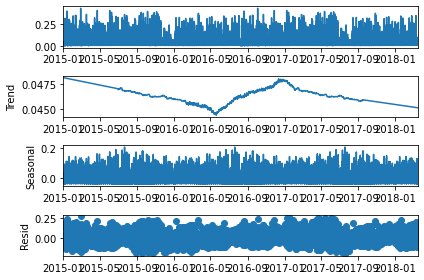

In [112]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive',period=np.prod(folds),extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


3
6
9


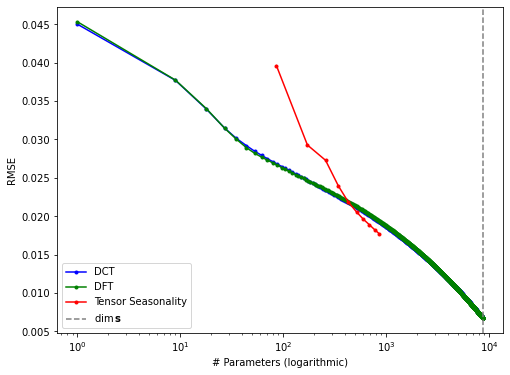

In [113]:
data -= decomposition.trend
data = data[len(data) % np.prod(folds):]

dct_errors, dft_errors = dct_dft_errors(data, np.prod(folds))
ten_errors, ten_params = tensor_error(data.values, folds=[24, 7, 52], ranks=list(range(1,11)))
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds)

### Traffic Dataset

In [114]:
train_datas, test_datas, lens, freqs = get_gluonts_dataset(dataset_name="traffic")

INFO:root:using dataset already processed in path /home/melih/.mxnet/gluon-ts/datasets/traffic.


14036    862
dtype: int64
H    862
dtype: int64


In [115]:
folds = [24, 7, 52]
freq="H"

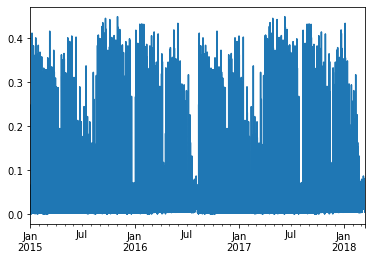

In [92]:
idx=0
data = get_plot_data(idx, train_datas, test_datas, freq)

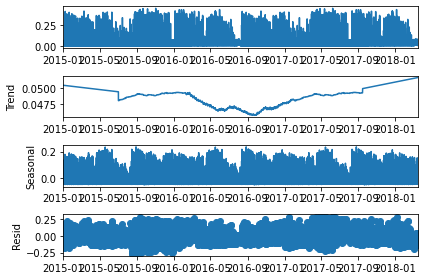

In [99]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive',period=np.prod(folds),extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


3
6
9


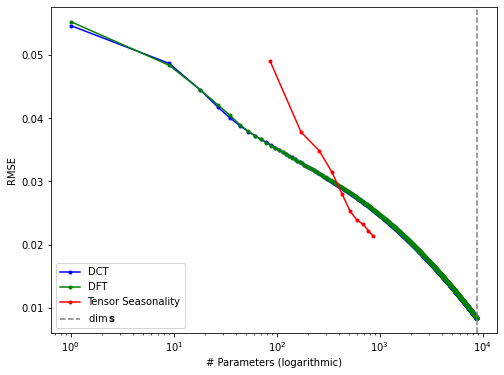

In [101]:
data -= decomposition.trend
data = data[len(data) % np.prod(folds):]

dct_errors, dft_errors = dct_dft_errors(data, np.prod(folds))
ten_errors, ten_params = tensor_error(data.values, folds=folds, ranks=list(range(1,11)))
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds)

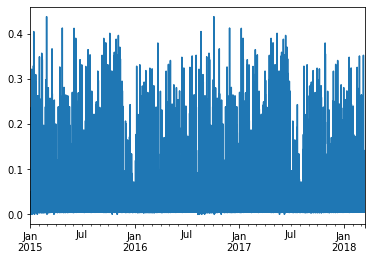

In [116]:
idx=1
data = get_plot_data(idx, train_datas, test_datas, freq)

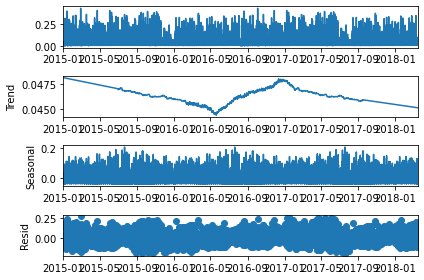

In [117]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive',period=np.prod(folds),extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


3
6
9


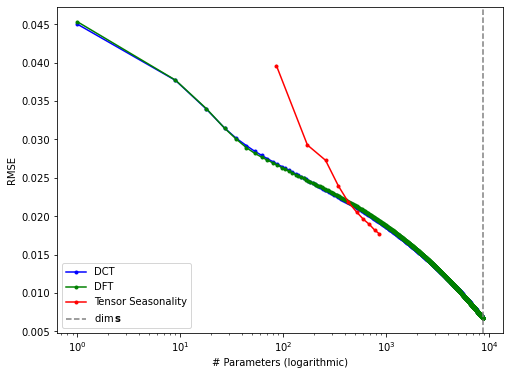

In [118]:
data -= decomposition.trend
data = data[len(data) % np.prod(folds):]

dct_errors, dft_errors = dct_dft_errors(data.values, np.prod(folds))
ten_errors, ten_params = tensor_error(data.values, folds=[24, 7, 52], ranks=list(range(1,11)))
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds)